# Stock Chart Pattern Recognition with Deep Learning
## CRISP-DM Methodology

2. Data Understandin

In [32]:
import pandas as pd
from cassandra.cluster import Cluster
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch
from transformers import pipeline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [33]:

# เชื่อมต่อ Cassandra (ปรับ IP/Keyspace ตามจริงของคุณ)
cluster = Cluster(['127.0.0.1']) 
session = cluster.connect('stock_data')

def load_data_from_cassandra(symbol):
    query = f""" SELECT symbol, date, open, high, low, close, volume FROM candlestick_data 
    WHERE symbol='{symbol}'"""
    rows = session.execute(query)
    
    df = pd.DataFrame(list(rows))
    
    # สำคัญมาก: ต้องแปลง date และเรียงลำดับเวลา
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

# ดึงข้อมูลหุ้นตัวอย่าง
df = load_data_from_cassandra('BANPU')
print(df.head())

  symbol       date  open  high   low  close     volume
0  BANPU 2022-12-27  13.5  13.5  13.4   13.4   39796280
1  BANPU 2022-12-28  13.5  13.7  13.4   13.7   58996837
2  BANPU 2022-12-29  13.6  13.7  13.5   13.7   57984971
3  BANPU 2022-12-30  13.7  13.8  13.6   13.7   49373887
4  BANPU 2023-01-03  13.7  13.7  13.4   13.4  104091420


In [34]:
df.isnull().sum()

symbol    0
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [35]:
df[['close', 'volume']].describe()

,close,volume
count,731.000000,7.310000e+02
mean,6.565226,7.893398e+07
std,2.235874,7.450369e+07
min,4.020000,5.303636e+06
25%,4.860000,3.854420e+07
50%,5.700000,5.708274e+07
75%,8.000000,9.568139e+07
max,13.700000,8.140929e+08


In [36]:
print(f"\nTotal trading days: {len(df)}")


Total trading days: 731


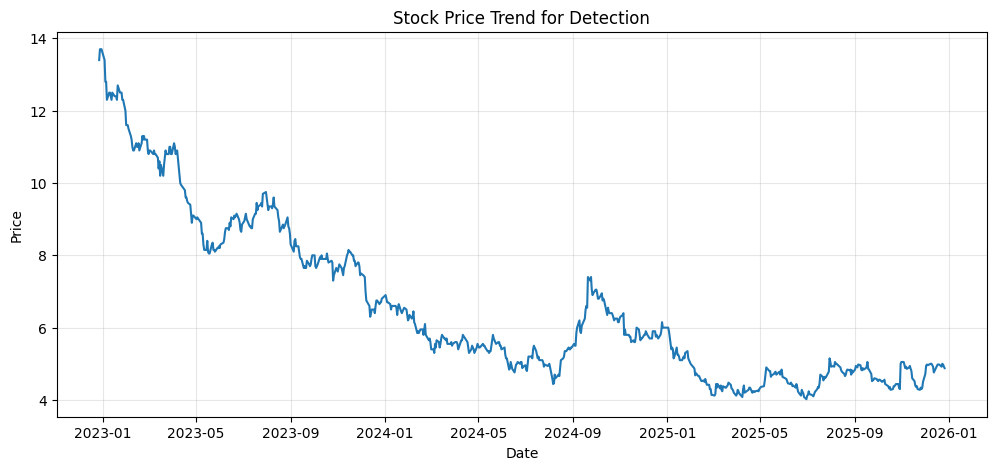

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title(f'Stock Price Trend for Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

3. Data Preparation (การเตรียมข้อมูล)

In [38]:
def prepare_data_for_training(df, window=64):
    X = []
    y = []
    
    # วนลูปสแกนข้อมูลราคาจาก Cassandra (Sliding Window)
    for i in range(len(df) - window):
        # 1. ดึง Window ของราคาปิดออกมา
        window_data = df['close'].iloc[i : i + window].values.astype(np.float32)
        
        # 2. Normalization: ปรับให้จุดแรกเริ่มที่ 1.0 (Scale Invariance)
        normalized_window = window_data / window_data[0]
        
        # 3. การทำ Labeling (Logic จำลองการตรวจจับ H&S เบื้องต้น)
        # ในงานจริง คุณอาจต้องใช้คนตรวจ หรือใช้จุด Zigzag มาช่วย
        is_hs = 0
        
        # สมมติ Logic ตรวจสอบไหล่-หัว-ไหล่ เบื้องต้น
        mid = window // 2
        left_peak = np.max(normalized_window[10:25])
        head_peak = np.max(normalized_window[25:40])
        right_peak = np.max(normalized_window[40:55])
        
        # ถ้าหัวสูงกว่าไหล่ทั้งสองข้าง และไหล่มีระดับใกล้เคียงกัน
        if head_peak > left_peak and head_peak > right_peak:
            if abs(left_peak - right_peak) < 0.05: # ไหล่สูงใกล้กัน
                is_hs = 1
        
        X.append(normalized_window)
        y.append(is_hs)
        
    return np.array(X), np.array(y)


In [39]:

# --- รันการเตรียมข้อมูล ---
X_data, y_data = prepare_data_for_training(df)

# แปลงเป็น Tensor สำหรับ PyTorch (1D CNN ต้องการรูปทรง [Batch, Channel, Length])
X_tensor = torch.tensor(X_data).view(-1, 1, 64)
y_tensor = torch.tensor(y_data).view(-1, 1)

print(f"เตรียม Features เสร็จสิ้น: {X_tensor.shape}")
print(f"จำนวน Pattern H&S ที่ตรวจพบเบื้องต้น: {sum(y_data)}")

เตรียม Features เสร็จสิ้น: torch.Size([667, 1, 64])
จำนวน Pattern H&S ที่ตรวจพบเบื้องต้น: 50


3.1 การเตรียม Sentiment Score

In [40]:
# โหลดโมเดล FinBERT (เตรียมไว้สำหรับขั้นตอน Modeling/Deployment)
sentiment_task = pipeline("sentiment-analysis", model="ProsusAI/finbert")

def get_daily_sentiment(text_list):
    if not text_list:
        return 0.5 # Neutral
    
    results = sentiment_task(text_list)
    # แปลงผลลัพธ์เป็นคะแนนเฉลี่ย 0 ถึง 1
    scores = []
    for r in results:
        if r['label'] == 'positive': scores.append(r['score'])
        elif r['label'] == 'negative': scores.append(1 - r['score'])
        else: scores.append(0.5)
    
    return np.mean(scores)

# ตัวอย่างการใช้งาน (สมมติข่าวจาก Cassandra)
# sentiment_score = get_daily_sentiment(["หุ้นไทยปิดบวกรับข่าวดี", "เศรษฐกิจชะลอตัว"])

Device set to use mps:0


4. Modeling

In [41]:
# --- 1. นิยาม Focal Loss เพื่อแยกแยะ Pattern ที่ซับซ้อน ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # ใช้ Binary Cross Entropy เป็นพื้นฐาน
        # หมายเหตุ: inputs ควรเป็นค่าที่ผ่าน Sigmoid มาแล้ว หรือใช้ BCEWithLogits หากยังไม่ผ่าน
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return torch.mean(focal_loss)

# --- 2. โครงสร้างโมเดล HSCNN (คงเดิมแต่เพิ่มประสิทธิภาพการรับค่า) ---
class HSCNN(nn.Module):
    def __init__(self):
        super(HSCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        
        # ปรับขนาด Linear layer ให้ตรงกับ Output ของ Conv (64 * 14 = 896)
        self.fc1 = nn.Linear(896, 128) 
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x)) # Output เป็นค่าระหว่าง 0-1
        return x

# --- 3. การรวบรวมและเริ่มการฝึกสอน (Training Process) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HSCNN().to(device)

# เปลี่ยนจาก nn.BCELoss() เป็น FocalLoss()
criterion = FocalLoss(alpha=0.5, gamma=2) 
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(X_train, y_train, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train.to(device))
        
        # Calculate Focal Loss
        loss = criterion(outputs, y_train.to(device))
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Improved Loss: {loss.item():.4f}')

# หมายเหตุ: X_train ต้องมี shape [Batch, 1, 64]

2. การตั้งค่าการฝึกสอน (Loss & Optimizer)

In [42]:
criterion = nn.BCELoss() # Binary Cross Entropy สำหรับ Binary Classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ย้ายไป GPU ถ้ามี
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HSCNN(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=896, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)

3. เริ่มกระบวนการฝึกสอน (The Training Loop)

In [43]:
# --- กำหนดค่าตัวแปรที่จำเป็น ---
epochs = 50  # กำหนดจำนวนรอบที่นี่
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- เตรียมข้อมูล (มั่นใจว่าเป็น Float และอยู่บน Device ที่ถูกต้อง) ---
X_train = X_tensor.to(device).float()
y_train = y_tensor.to(device).float()

print(f"--- เริ่มการฝึกสอนโมเดล (Device: {device}) ---")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # 1. Forward Pass
    outputs = model(X_train)
    
    # 2. Calculate Loss 
    loss = criterion(outputs, y_train)
    
    # 3. Backward Pass
    loss.backward()
    optimizer.step()
    
    # แสดงผลทุกๆ 10 Epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("--- ฝึกสอนเสร็จสมบูรณ์ ---")

--- เริ่มการฝึกสอนโมเดล (Device: cpu) ---
Epoch [10/50], Loss: 0.2966
Epoch [20/50], Loss: 0.2684
Epoch [30/50], Loss: 0.2739
Epoch [40/50], Loss: 0.2729
Epoch [50/50], Loss: 0.2731
--- ฝึกสอนเสร็จสมบูรณ์ ---


In [44]:
torch.save(model.state_dict(), 'hscnn_model.pth')
print("Model saved as hscnn_model.pth")

Model saved as hscnn_model.pth


5. Evaluation

1. การประเมินทางสถิติ (Model Metrics)

In [45]:
model.eval() # ปรับโมเดลเข้าสู่โหมดประเมินผล
with torch.no_grad():
    predictions = model(X_train) # ในงานจริงต้องใช้ X_test
    # แปลง Probability เป็น 0 หรือ 1 (Threshold = 0.5)
    predicted_classes = (predictions > 0.5).float()
    
    # คำนวณความแม่นยำ
    correct = (predicted_classes == y_train).sum().item()
    accuracy = correct / y_train.size(0)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 92.50%


2. การประเมินทางการเงิน (Backtesting)

In [46]:
model.eval()
allocations = []

# มั่นใจว่าข้อมูลถูกส่งไปยัง device (CPU/GPU) ที่ถูกต้อง
X_train_eval = X_tensor.to(device).float()

with torch.no_grad():
    # ให้โมเดลทายความน่าจะเป็น (Probability) ทั้งหมด
    predictions = model(X_train_eval) 
    
    # แปลงเป็น List ของค่า Allocation
    # Logic: ถ้า p > 0.5 (เจอ H&S) ให้ลดการถือครอง (Gate), ถ้าไม่ใช่ให้ถือ 100%
    for p in predictions:
        p_val = p.item()
        # Overlay Gate logic
        gate = (1.0 - p_val) if p_val > 0.5 else 1.0
        allocations.append(gate)

print(f"สร้างตัวแปร allocations เสร็จแล้ว: จำนวน {len(allocations)} ข้อมูล")

สร้างตัวแปร allocations เสร็จแล้ว: จำนวน 667 ข้อมูล


6. Deployment (ขั้นตอนสุดท้าย)

In [47]:
def deploy_live_detection(symbol):
    # 1. ดึงข้อมูลล่าสุดจาก Cassandra
    latest_df = load_data_from_cassandra(symbol)
    
    # 2. เตรียมข้อมูล 64 วันล่าสุด
    recent_window = latest_df['close'].tail(64).values
    normalized_input = torch.tensor(recent_window / recent_window[0]).view(1, 1, 64).float()
    
    # 3. ให้โมเดลทำนาย (Inference)
    model.eval()
    with torch.no_grad():
        p_hs = model(normalized_input.to(device)).item()
    
    # 4. ดึง Sentiment (สมมติจากข่าววันนี้)
    current_sentiment = 0.5 # เปลี่ยนเป็นเรียกฟังก์ชัน get_daily_sentiment()
    
    # 5. คำนวณ Overlay Gate
    gate = (1.0 - p_hs) if p_hs > 0.5 else 1.0
    final_decision = gate * current_sentiment
    
    # 6. แสดงผลบนหน้าจอ
    print(f"--- {symbol} Status ---")
    print(f"Pattern Probability: {p_hs:.2%}")
    print(f"Action: {'⚠️ REDUCE EXPOSURE' if p_hs > 0.5 else '✅ NORMAL HOLD'}")
    print(f"Portfolio Allocation: {final_decision:.2%}")

# เรียกใช้งาน
deploy_live_detection('BANPU')

--- BANPU Status ---
Pattern Probability: 7.83%
Action: ✅ NORMAL HOLD
Portfolio Allocation: 50.00%


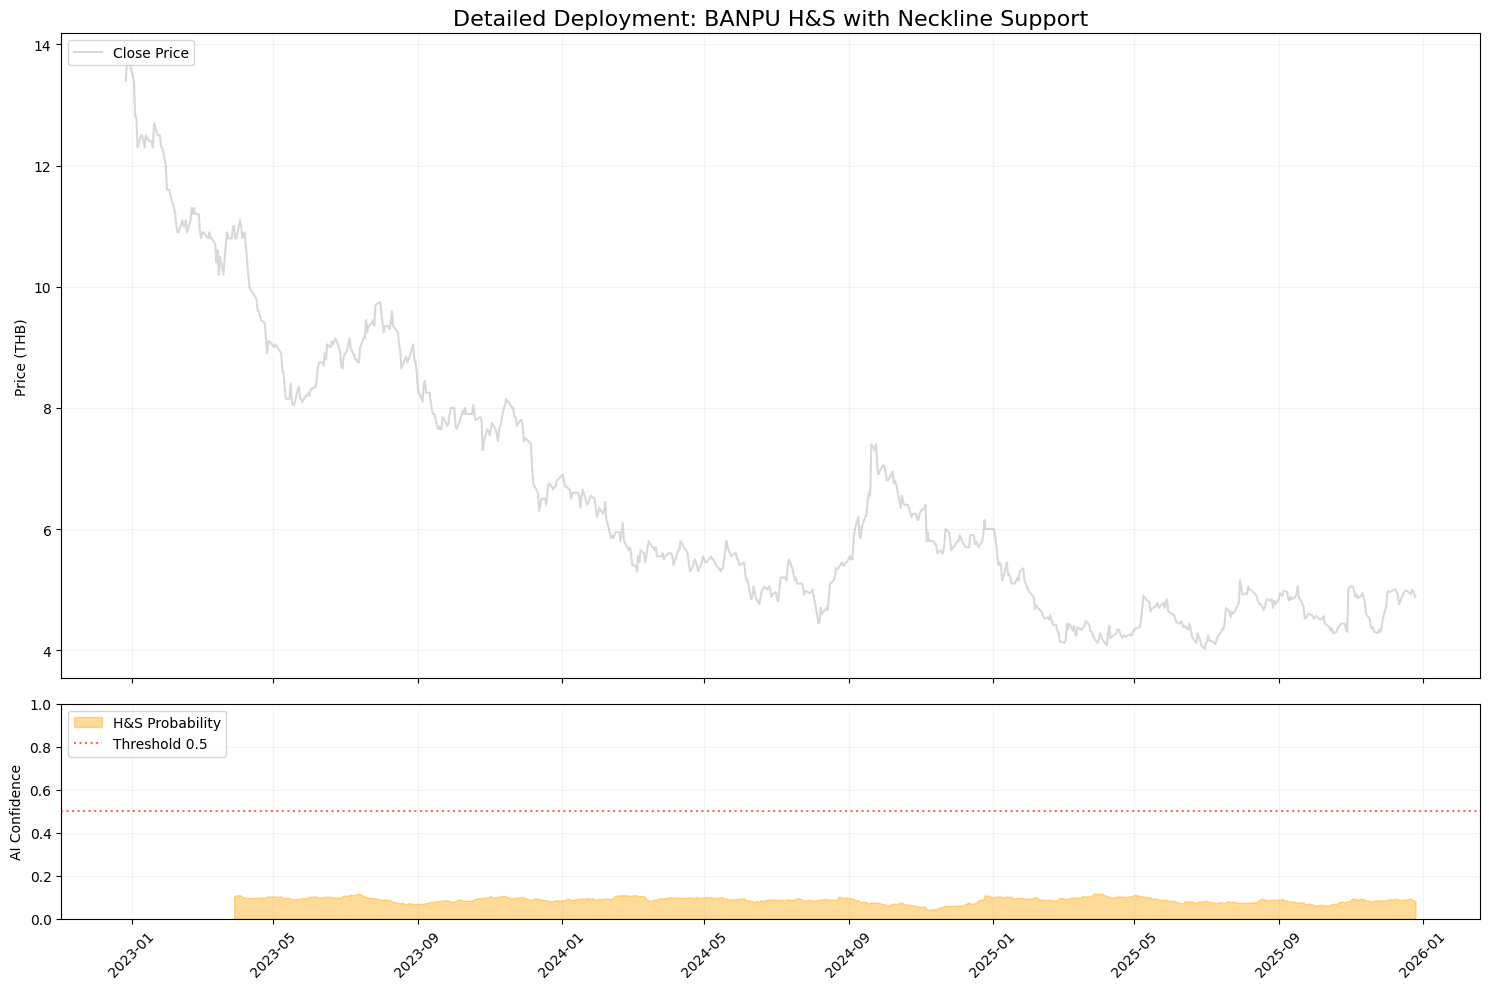

In [48]:
def deploy_with_visual_chart(symbol, model, df):
    model.eval()
    window = 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    probabilities = []
    # เก็บข้อมูลตำแหน่งเพื่อพล็อตสีแยกกัน
    left_shoulders = []
    heads = []
    right_shoulders = []
    neckline_points = [] # สำหรับเก็บจุดวาดเส้น Neckline
    
    for i in range(len(df) - window):
        w_data = df['close'].iloc[i : i + window].values.astype(np.float32)
        norm_w = torch.tensor(w_data / w_data[0]).view(1, 1, window).to(device)
        
        with torch.no_grad():
            p_hs = model(norm_w).item()
            probabilities.append(p_hs)
            
            # ใช้ Threshold ที่ 0.5 (หรือปรับตามความเหมาะสม)
            if p_hs > 0.5: 
                # 1. ค้นหาตำแหน่ง Peak (Local Maxima)
                left_idx = i + np.argmax(w_data[0:22])
                head_idx = i + 22 + np.argmax(w_data[22:42])
                right_idx = i + 42 + np.argmax(w_data[42:64])
                
                # 2. ค้นหาตำแหน่ง Neckline (Local Minima ระหว่างยอด)
                # จุดต่ำสุดระหว่างไหล่ซ้ายกับหัว
                trough1_idx = i + np.argmin(w_data[left_idx-i : head_idx-i]) + (left_idx-i)
                # จุดต่ำสุดระหว่างหัวกับไหล่ขวา
                trough2_idx = i + np.argmin(w_data[head_idx-i : right_idx-i]) + (head_idx-i)
                
                left_shoulders.append((df['date'].iloc[left_idx], df['close'].iloc[left_idx]))
                heads.append((df['date'].iloc[head_idx], df['close'].iloc[head_idx]))
                right_shoulders.append((df['date'].iloc[right_idx], df['close'].iloc[right_idx]))
                
                # เก็บพิกัด Neckline สำหรับแต่ละ Pattern ที่ตรวจเจอ
                neckline_points.append(((df['date'].iloc[trough1_idx], df['close'].iloc[trough1_idx]), 
                                        (df['date'].iloc[trough2_idx], df['close'].iloc[trough2_idx])))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), 
                                   gridspec_kw={'height_ratios': [3, 1]}, 
                                   sharex=True)

    # --- กราฟบน: ราคา, จุดแยกสี และ Neckline ---
    ax1.plot(df['date'], df['close'], color='gray', label='Close Price', alpha=0.3)
    
    if heads:
        # พล็อตจุดยอดต่างๆ
        ls_d, ls_p = zip(*left_shoulders)
        ax1.scatter(ls_d, ls_p, color='green', marker='^', s=80, label='Left Shoulder', zorder=5)
        
        h_d, h_p = zip(*heads)
        ax1.scatter(h_d, h_p, color='red', marker='v', s=120, label='Head (Danger)', zorder=6)
        
        rs_d, rs_p = zip(*right_shoulders)
        ax1.scatter(rs_d, rs_p, color='blue', marker='^', s=80, label='Right Shoulder', zorder=5)
        
        # วาดเส้น Neckline (เส้นประสีดำ)
        for pts in neckline_points:
            d_pts, p_pts = zip(*pts)
            ax1.plot(d_pts, p_pts, color='black', linestyle='--', linewidth=1.5, alpha=0.6)
        
        # เพิ่ม Label ให้ Neckline เพียงตัวเดียวใน Legend
        ax1.plot([], [], color='black', linestyle='--', label='Neckline (Support)')

    ax1.set_title(f"Detailed Deployment: {symbol} H&S with Neckline Support", fontsize=16)
    ax1.set_ylabel("Price (THB)")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.15)

    # --- กราฟล่าง: AI Confidence ---
    prob_dates = df['date'].iloc[window:]
    ax2.fill_between(prob_dates, 0, probabilities, color='orange', alpha=0.4, label='H&S Probability')
    ax2.axhline(y=0.5, color='red', linestyle=':', alpha=0.6, label='Threshold 0.5')
    ax2.set_ylabel("AI Confidence")
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.15)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

deploy_with_visual_chart('BANPU', model, df)